In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%%bash
pip install tqdm
pip install --upgrade torch
pip install numpy
pip install matplotlib

  Found existing installation: torch 1.6.0
    Uninstalling torch-1.6.0:
      Successfully uninstalled torch-1.6.0


You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import os
import math

import torch
import torchvision
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

from data_utils import cifar10, cifar10_classes, matplotlib_imshow, plot_history
from train_utils import train, evaluate, device
from models.mlp import MLP

In [4]:
HPS = dict(
    batch_size=128,
    epochs=50,
)

model_dir = './models/cifar10_lr_schedules'

train_ds, test_ds = cifar10(batch_size=HPS['batch_size'])

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
import torch
import torch.nn as nn
from torchvision.models.utils import load_state_dict_from_url


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
#         x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

# Custom added
def resnet9(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet9', BasicBlock, [1, 1, 1, 1], pretrained, progress,
                   **kwargs)

def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [6]:
epochs = 50
model = resnet18(num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
history = train(train_ds, test_ds, optimizer, model, scheduler=scheduler, epochs=epochs)
torch.save({
    'model_state_dict': model.state_dict(),
    'opt_state_dict': optimizer.state_dict(),
    'history': history
}, f'{model_dir}_cosine_annealing')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Loss: 2.19572229763431 Batch Accuracy: 0.22856


  2%|▏         | 1/50 [00:46<38:00, 46.55s/it]

Test Set evaluation: Loss: 1.8390163816983187 Test Accuracy: 0.3192
Epoch 1: Loss: 1.646004019186015 Batch Accuracy: 0.3882


  4%|▍         | 2/50 [01:33<37:14, 46.56s/it]

Test Set evaluation: Loss: 1.5200861405722703 Test Accuracy: 0.4348
Epoch 2: Loss: 1.362083135663396 Batch Accuracy: 0.50084


  6%|▌         | 3/50 [02:19<36:30, 46.60s/it]

Test Set evaluation: Loss: 1.525552680220785 Test Accuracy: 0.4609
Epoch 3: Loss: 1.0823954488615246 Batch Accuracy: 0.61264


  8%|▊         | 4/50 [03:07<35:51, 46.77s/it]

Test Set evaluation: Loss: 1.1866369436058817 Test Accuracy: 0.6058
Epoch 4: Loss: 0.8841106079118636 Batch Accuracy: 0.69162


 10%|█         | 5/50 [03:54<35:16, 47.03s/it]

Test Set evaluation: Loss: 0.9902518444423434 Test Accuracy: 0.6559
Epoch 5: Loss: 0.7818154438072459 Batch Accuracy: 0.72932


 12%|█▏        | 6/50 [04:42<34:43, 47.35s/it]

Test Set evaluation: Loss: 0.9839606594435776 Test Accuracy: 0.6636
Epoch 6: Loss: 0.7126093278150729 Batch Accuracy: 0.7565


 14%|█▍        | 7/50 [05:30<34:02, 47.50s/it]

Test Set evaluation: Loss: 0.8943652344655387 Test Accuracy: 0.7066
Epoch 7: Loss: 0.663122104256964 Batch Accuracy: 0.77342


 16%|█▌        | 8/50 [06:18<33:19, 47.61s/it]

Test Set evaluation: Loss: 0.8841273867631261 Test Accuracy: 0.6961
Epoch 8: Loss: 0.6298342148208862 Batch Accuracy: 0.78508


 18%|█▊        | 9/50 [07:06<32:34, 47.66s/it]

Test Set evaluation: Loss: 0.9489282656319534 Test Accuracy: 0.6914
Epoch 9: Loss: 0.6069802771443906 Batch Accuracy: 0.79142


 20%|██        | 10/50 [07:53<31:46, 47.65s/it]

Test Set evaluation: Loss: 0.8393245603464827 Test Accuracy: 0.7242
Epoch 10: Loss: 0.5922908338591876 Batch Accuracy: 0.7974


 22%|██▏       | 11/50 [08:41<30:58, 47.65s/it]

Test Set evaluation: Loss: 1.030965472323985 Test Accuracy: 0.6621
Epoch 11: Loss: 0.5671015234706956 Batch Accuracy: 0.80542


 24%|██▍       | 12/50 [09:29<30:16, 47.80s/it]

Test Set evaluation: Loss: 1.5248875527442256 Test Accuracy: 0.6215
Epoch 12: Loss: 0.5575887677462205 Batch Accuracy: 0.80918


 26%|██▌       | 13/50 [10:17<29:28, 47.80s/it]

Test Set evaluation: Loss: 0.8189109895802751 Test Accuracy: 0.7378
Epoch 13: Loss: 0.5392082626252528 Batch Accuracy: 0.81466


 28%|██▊       | 14/50 [11:05<28:39, 47.75s/it]

Test Set evaluation: Loss: 0.7699026329607903 Test Accuracy: 0.7458
Epoch 14: Loss: 0.5202156360192067 Batch Accuracy: 0.82296


 30%|███       | 15/50 [11:52<27:51, 47.75s/it]

Test Set evaluation: Loss: 0.706934572397908 Test Accuracy: 0.7856
Epoch 15: Loss: 0.5119955837726593 Batch Accuracy: 0.82496


 32%|███▏      | 16/50 [12:40<27:07, 47.85s/it]

Test Set evaluation: Loss: 0.6527216872082481 Test Accuracy: 0.7805
Epoch 16: Loss: 0.4978922912684243 Batch Accuracy: 0.83016


 34%|███▍      | 17/50 [13:28<26:19, 47.87s/it]

Test Set evaluation: Loss: 0.955737063401862 Test Accuracy: 0.7002
Epoch 17: Loss: 0.47927077888222913 Batch Accuracy: 0.83768


 36%|███▌      | 18/50 [14:16<25:32, 47.90s/it]

Test Set evaluation: Loss: 0.7632598978809163 Test Accuracy: 0.7385
Epoch 18: Loss: 0.47097979131562023 Batch Accuracy: 0.84004


 38%|███▊      | 19/50 [15:04<24:45, 47.93s/it]

Test Set evaluation: Loss: 0.5772737234453612 Test Accuracy: 0.8044
Epoch 19: Loss: 0.4630652070426575 Batch Accuracy: 0.8412


 40%|████      | 20/50 [15:52<23:57, 47.92s/it]

Test Set evaluation: Loss: 0.47309396670588966 Test Accuracy: 0.8364
Epoch 20: Loss: 0.4401929931872336 Batch Accuracy: 0.84946


 42%|████▏     | 21/50 [16:40<23:07, 47.85s/it]

Test Set evaluation: Loss: 0.6366041691242894 Test Accuracy: 0.7876
Epoch 21: Loss: 0.43225903012563505 Batch Accuracy: 0.8518


 44%|████▍     | 22/50 [17:28<22:22, 47.95s/it]

Test Set evaluation: Loss: 0.4881171474728403 Test Accuracy: 0.8327
Epoch 22: Loss: 0.41517735922428045 Batch Accuracy: 0.85808


 46%|████▌     | 23/50 [18:16<21:34, 47.93s/it]

Test Set evaluation: Loss: 0.5506112279394005 Test Accuracy: 0.8195
Epoch 23: Loss: 0.4036698738860962 Batch Accuracy: 0.86166


 48%|████▊     | 24/50 [19:04<20:45, 47.89s/it]

Test Set evaluation: Loss: 0.6540087714225431 Test Accuracy: 0.7885
Epoch 24: Loss: 0.39225000066830373 Batch Accuracy: 0.86586


 50%|█████     | 25/50 [19:52<19:58, 47.96s/it]

Test Set evaluation: Loss: 0.5431746534908874 Test Accuracy: 0.8261
Epoch 25: Loss: 0.37454700755798603 Batch Accuracy: 0.87142


 52%|█████▏    | 26/50 [20:40<19:10, 47.93s/it]

Test Set evaluation: Loss: 0.52601778205437 Test Accuracy: 0.8359
Epoch 26: Loss: 0.3639804249453118 Batch Accuracy: 0.8757


 54%|█████▍    | 27/50 [21:28<18:22, 47.91s/it]

Test Set evaluation: Loss: 0.8269503927683528 Test Accuracy: 0.743
Epoch 27: Loss: 0.3467175988361354 Batch Accuracy: 0.8808


 56%|█████▌    | 28/50 [22:16<17:34, 47.95s/it]

Test Set evaluation: Loss: 0.6296658715869807 Test Accuracy: 0.8103
Epoch 28: Loss: 0.32551549367435145 Batch Accuracy: 0.88928


 58%|█████▊    | 29/50 [23:04<16:47, 47.99s/it]

Test Set evaluation: Loss: 0.6295880384837524 Test Accuracy: 0.7995
Epoch 29: Loss: 0.3127672000385611 Batch Accuracy: 0.89318


 60%|██████    | 30/50 [23:52<16:00, 48.05s/it]

Test Set evaluation: Loss: 0.5445162163505072 Test Accuracy: 0.819
Epoch 30: Loss: 0.2998786673064122 Batch Accuracy: 0.89732


 62%|██████▏   | 31/50 [24:40<15:13, 48.07s/it]

Test Set evaluation: Loss: 0.4186487820329545 Test Accuracy: 0.8623
Epoch 31: Loss: 0.2831972488356978 Batch Accuracy: 0.90242


 64%|██████▍   | 32/50 [25:29<14:30, 48.37s/it]

Test Set evaluation: Loss: 0.3886525817686998 Test Accuracy: 0.865
Epoch 32: Loss: 0.26449596948559634 Batch Accuracy: 0.90828


 66%|██████▌   | 33/50 [26:17<13:39, 48.18s/it]

Test Set evaluation: Loss: 0.38000583856166165 Test Accuracy: 0.8701
Epoch 33: Loss: 0.24024164440381862 Batch Accuracy: 0.9176


 68%|██████▊   | 34/50 [27:05<12:50, 48.18s/it]

Test Set evaluation: Loss: 0.3866312366120423 Test Accuracy: 0.8672
Epoch 34: Loss: 0.22848332961044654 Batch Accuracy: 0.92224


 70%|███████   | 35/50 [27:53<12:00, 48.06s/it]

Test Set evaluation: Loss: 0.3279959340638752 Test Accuracy: 0.8886
Epoch 35: Loss: 0.20369755240428783 Batch Accuracy: 0.93048


 72%|███████▏  | 36/50 [28:41<11:11, 47.97s/it]

Test Set evaluation: Loss: 0.3286024356567407 Test Accuracy: 0.8937
Epoch 36: Loss: 0.1865375463081443 Batch Accuracy: 0.93732


 74%|███████▍  | 37/50 [29:29<10:23, 47.96s/it]

Test Set evaluation: Loss: 0.34282144517460955 Test Accuracy: 0.8866
Epoch 37: Loss: 0.16722741262877688 Batch Accuracy: 0.94276


 76%|███████▌  | 38/50 [30:16<09:35, 47.95s/it]

Test Set evaluation: Loss: 0.29739417116853256 Test Accuracy: 0.9021
Epoch 38: Loss: 0.14614309783062668 Batch Accuracy: 0.95026


 78%|███████▊  | 39/50 [31:04<08:47, 47.97s/it]

Test Set evaluation: Loss: 0.30970219852803627 Test Accuracy: 0.8957
Epoch 39: Loss: 0.12613205563115037 Batch Accuracy: 0.95576


 80%|████████  | 40/50 [31:52<07:59, 47.91s/it]

Test Set evaluation: Loss: 0.33456489330605615 Test Accuracy: 0.8976
Epoch 40: Loss: 0.1078128607519676 Batch Accuracy: 0.96258


 82%|████████▏ | 41/50 [32:40<07:11, 47.95s/it]

Test Set evaluation: Loss: 0.2606952282824094 Test Accuracy: 0.9191
Epoch 41: Loss: 0.0806831121849625 Batch Accuracy: 0.97312


 84%|████████▍ | 42/50 [33:28<06:23, 47.98s/it]

Test Set evaluation: Loss: 0.2621753381777413 Test Accuracy: 0.9183
Epoch 42: Loss: 0.06773311786277367 Batch Accuracy: 0.97754


 86%|████████▌ | 43/50 [34:16<05:35, 47.97s/it]

Test Set evaluation: Loss: 0.2428488359798359 Test Accuracy: 0.9266
Epoch 43: Loss: 0.05133079546753822 Batch Accuracy: 0.98306


 88%|████████▊ | 44/50 [35:04<04:48, 48.02s/it]

Test Set evaluation: Loss: 0.23595401418359974 Test Accuracy: 0.9291
Epoch 44: Loss: 0.03820564221147724 Batch Accuracy: 0.98806


 90%|█████████ | 45/50 [35:52<04:00, 48.02s/it]

Test Set evaluation: Loss: 0.23367766404076468 Test Accuracy: 0.9324
Epoch 45: Loss: 0.027188736393981044 Batch Accuracy: 0.99258


 92%|█████████▏| 46/50 [36:41<03:12, 48.09s/it]

Test Set evaluation: Loss: 0.21849130513735965 Test Accuracy: 0.936
Epoch 46: Loss: 0.02261001884858684 Batch Accuracy: 0.9936


 94%|█████████▍| 47/50 [37:29<02:24, 48.02s/it]

Test Set evaluation: Loss: 0.21939355979048752 Test Accuracy: 0.9377
Epoch 47: Loss: 0.019491237153530197 Batch Accuracy: 0.99526


 96%|█████████▌| 48/50 [38:17<01:36, 48.07s/it]

Test Set evaluation: Loss: 0.21574665582444094 Test Accuracy: 0.939
Epoch 48: Loss: 0.016392902645003767 Batch Accuracy: 0.99562


 98%|█████████▊| 49/50 [39:05<00:48, 48.17s/it]

Test Set evaluation: Loss: 0.2165329069653644 Test Accuracy: 0.9387
Epoch 49: Loss: 0.014819677508867268 Batch Accuracy: 0.99658


100%|██████████| 50/50 [39:53<00:00, 47.87s/it]

Test Set evaluation: Loss: 0.21655989202517498 Test Accuracy: 0.9391


Test Set evaluation: Loss: 0.21655989202517498 Test Accuracy: 0.9391


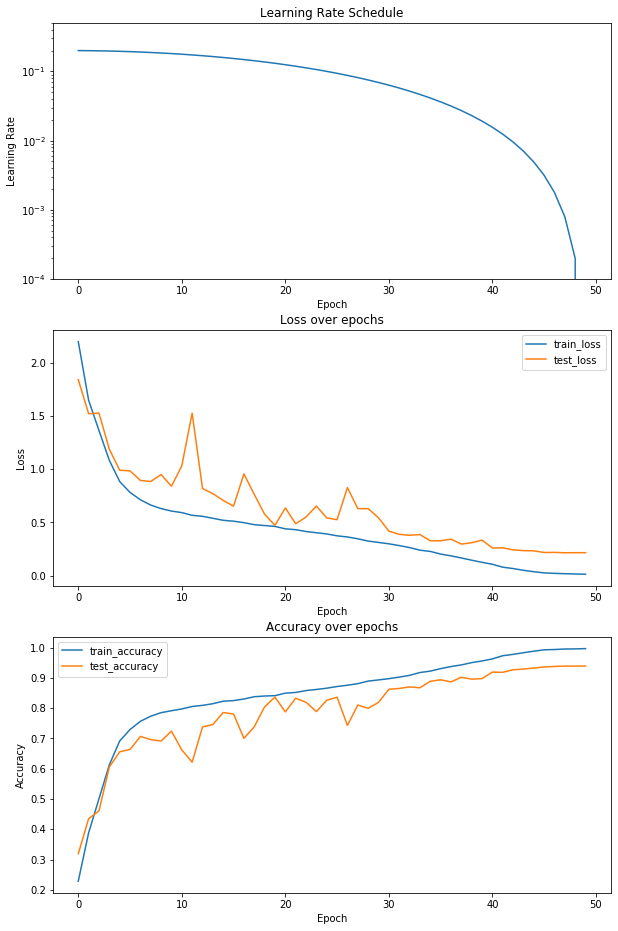

In [7]:
checkpoint = torch.load(f'{model_dir}_cosine_annealing')
r18 = resnet18(num_classes=10)
r18.to(device)
r18.load_state_dict(checkpoint['model_state_dict'])
evaluate(test_ds, r18, nn.CrossEntropyLoss())
plot_history(checkpoint['history'])

In [8]:
epochs = 20
model = resnet18(num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
history = train(train_ds, test_ds, optimizer, model, scheduler=scheduler, epochs=epochs)
torch.save({
    'model_state_dict': model.state_dict(),
    'opt_state_dict': optimizer.state_dict(),
    'history': history
}, f'{model_dir}_cosine_annealing_20')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Loss: 2.2367769958418044 Batch Accuracy: 0.20004


  5%|▌         | 1/20 [00:47<15:06, 47.69s/it]

Test Set evaluation: Loss: 1.8550937568085104 Test Accuracy: 0.2829
Epoch 1: Loss: 1.7367729482138554 Batch Accuracy: 0.34824


 10%|█         | 2/20 [01:35<14:19, 47.74s/it]

Test Set evaluation: Loss: 1.6260097162633003 Test Accuracy: 0.3831
Epoch 2: Loss: 1.4761076842427558 Batch Accuracy: 0.45512


 15%|█▌        | 3/20 [02:23<13:34, 47.93s/it]

Test Set evaluation: Loss: 1.315597009055222 Test Accuracy: 0.522
Epoch 3: Loss: 1.223141569920513 Batch Accuracy: 0.55988


 20%|██        | 4/20 [03:11<12:46, 47.93s/it]

Test Set evaluation: Loss: 1.2806483167636245 Test Accuracy: 0.5434
Epoch 4: Loss: 1.0177716035062394 Batch Accuracy: 0.63654


 25%|██▌       | 5/20 [04:00<12:00, 48.04s/it]

Test Set evaluation: Loss: 1.1307953249050091 Test Accuracy: 0.6077
Epoch 5: Loss: 0.8549197639345818 Batch Accuracy: 0.70068


 30%|███       | 6/20 [04:48<11:13, 48.08s/it]

Test Set evaluation: Loss: 1.1696747797953932 Test Accuracy: 0.6254
Epoch 6: Loss: 0.750994061341371 Batch Accuracy: 0.73892


 35%|███▌      | 7/20 [05:36<10:24, 48.05s/it]

Test Set evaluation: Loss: 0.9649937077413632 Test Accuracy: 0.6836
Epoch 7: Loss: 0.6645291793681777 Batch Accuracy: 0.77196


 40%|████      | 8/20 [06:24<09:37, 48.10s/it]

Test Set evaluation: Loss: 0.7157950710646713 Test Accuracy: 0.7538
Epoch 8: Loss: 0.6035346989436527 Batch Accuracy: 0.79238


 45%|████▌     | 9/20 [07:12<08:49, 48.12s/it]

Test Set evaluation: Loss: 0.8173255562027798 Test Accuracy: 0.7232
Epoch 9: Loss: 0.5550100154736463 Batch Accuracy: 0.80998


 50%|█████     | 10/20 [08:00<08:00, 48.07s/it]

Test Set evaluation: Loss: 0.6963578632360772 Test Accuracy: 0.7703
Epoch 10: Loss: 0.5068997377172455 Batch Accuracy: 0.82552


 55%|█████▌    | 11/20 [08:48<07:12, 48.03s/it]

Test Set evaluation: Loss: 0.5927531617351726 Test Accuracy: 0.8026
Epoch 11: Loss: 0.46244233480804714 Batch Accuracy: 0.84138


 60%|██████    | 12/20 [09:36<06:24, 48.11s/it]

Test Set evaluation: Loss: 0.5996125755430777 Test Accuracy: 0.7956
Epoch 12: Loss: 0.4162416680313437 Batch Accuracy: 0.85692


 65%|██████▌   | 13/20 [10:24<05:36, 48.07s/it]

Test Set evaluation: Loss: 0.6485789218280889 Test Accuracy: 0.7906
Epoch 13: Loss: 0.364838047215091 Batch Accuracy: 0.87508


 70%|███████   | 14/20 [11:13<04:48, 48.15s/it]

Test Set evaluation: Loss: 0.4795410757577872 Test Accuracy: 0.8386
Epoch 14: Loss: 0.3157179051881556 Batch Accuracy: 0.8917


 75%|███████▌  | 15/20 [12:01<04:00, 48.09s/it]

Test Set evaluation: Loss: 0.46874595631526994 Test Accuracy: 0.8449
Epoch 15: Loss: 0.26717197277661786 Batch Accuracy: 0.90716


 80%|████████  | 16/20 [12:49<03:12, 48.18s/it]

Test Set evaluation: Loss: 0.3573890401969982 Test Accuracy: 0.8751
Epoch 16: Loss: 0.21928594055611764 Batch Accuracy: 0.9246


 85%|████████▌ | 17/20 [13:37<02:24, 48.09s/it]

Test Set evaluation: Loss: 0.3063606706601155 Test Accuracy: 0.9001
Epoch 17: Loss: 0.17394223536752984 Batch Accuracy: 0.9411


 90%|█████████ | 18/20 [14:25<01:36, 48.05s/it]

Test Set evaluation: Loss: 0.28801806082453907 Test Accuracy: 0.904
Epoch 18: Loss: 0.13661759468676793 Batch Accuracy: 0.9538


 95%|█████████▌| 19/20 [15:13<00:47, 47.99s/it]

Test Set evaluation: Loss: 0.25882629786111133 Test Accuracy: 0.9146
Epoch 19: Loss: 0.11882629534205817 Batch Accuracy: 0.96048


100%|██████████| 20/20 [16:01<00:00, 48.06s/it]

Test Set evaluation: Loss: 0.2493019983926906 Test Accuracy: 0.9166


Test Set evaluation: Loss: 0.2493019983926906 Test Accuracy: 0.9166


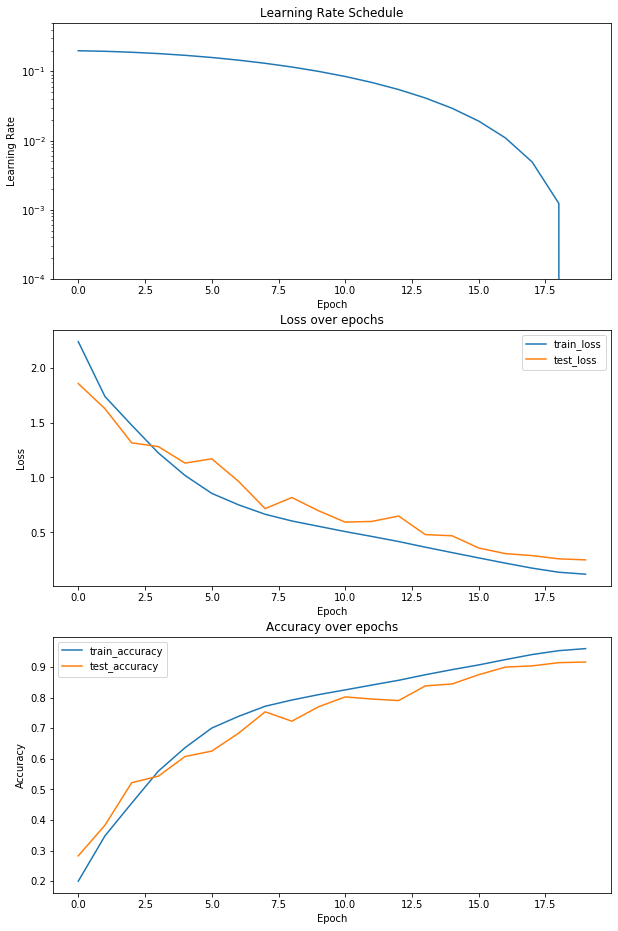

In [9]:
checkpoint = torch.load(f'{model_dir}_cosine_annealing_20')
r18 = resnet18(num_classes=10)
r18.to(device)
r18.load_state_dict(checkpoint['model_state_dict'])
evaluate(test_ds, r18, nn.CrossEntropyLoss())
plot_history(checkpoint['history'])

In [10]:
epochs = 30
model = resnet18(num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
history = train(train_ds, test_ds, optimizer, model, scheduler=scheduler, epochs=epochs)
torch.save({
    'model_state_dict': model.state_dict(),
    'opt_state_dict': optimizer.state_dict(),
    'history': history
}, f'{model_dir}_cosine_annealing_30')

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0: Loss: 2.218901713790796 Batch Accuracy: 0.20654


  3%|▎         | 1/30 [00:48<23:15, 48.12s/it]

Test Set evaluation: Loss: 1.7901582476458973 Test Accuracy: 0.3393
Epoch 1: Loss: 1.6565460481911973 Batch Accuracy: 0.37932


  7%|▋         | 2/30 [01:36<22:27, 48.12s/it]

Test Set evaluation: Loss: 1.5114704536486276 Test Accuracy: 0.4518
Epoch 2: Loss: 1.368369714683279 Batch Accuracy: 0.50008


 10%|█         | 3/30 [02:24<21:37, 48.07s/it]

Test Set evaluation: Loss: 1.2409730138657968 Test Accuracy: 0.5628
Epoch 3: Loss: 1.0747871371486304 Batch Accuracy: 0.61928


 13%|█▎        | 4/30 [03:12<20:51, 48.13s/it]

Test Set evaluation: Loss: 1.046029274222217 Test Accuracy: 0.6374
Epoch 4: Loss: 0.8641900254027618 Batch Accuracy: 0.69694


 17%|█▋        | 5/30 [04:00<20:04, 48.17s/it]

Test Set evaluation: Loss: 0.8389180970342853 Test Accuracy: 0.7058
Epoch 5: Loss: 0.7436581273822833 Batch Accuracy: 0.74388


 20%|██        | 6/30 [04:49<19:16, 48.20s/it]

Test Set evaluation: Loss: 1.3459167910527579 Test Accuracy: 0.6058
Epoch 6: Loss: 0.686921655598199 Batch Accuracy: 0.76492


 23%|██▎       | 7/30 [05:37<18:27, 48.15s/it]

Test Set evaluation: Loss: 0.8178360394284695 Test Accuracy: 0.7279
Epoch 7: Loss: 0.6418123941134919 Batch Accuracy: 0.77948


 27%|██▋       | 8/30 [06:24<17:37, 48.08s/it]

Test Set evaluation: Loss: 0.678705745105502 Test Accuracy: 0.7711
Epoch 8: Loss: 0.6023954516634002 Batch Accuracy: 0.79248


 30%|███       | 9/30 [07:12<16:49, 48.07s/it]

Test Set evaluation: Loss: 0.6910962402066098 Test Accuracy: 0.7627
Epoch 9: Loss: 0.5692418339612234 Batch Accuracy: 0.80384


 33%|███▎      | 10/30 [08:01<16:02, 48.12s/it]

Test Set evaluation: Loss: 0.7313930539390708 Test Accuracy: 0.7499
Epoch 10: Loss: 0.5476667970190268 Batch Accuracy: 0.8111


 37%|███▋      | 11/30 [08:49<15:12, 48.04s/it]

Test Set evaluation: Loss: 0.9080916477155082 Test Accuracy: 0.7097
Epoch 11: Loss: 0.5209739776828405 Batch Accuracy: 0.82244


 40%|████      | 12/30 [09:37<14:24, 48.04s/it]

Test Set evaluation: Loss: 0.9054346658006499 Test Accuracy: 0.6978
Epoch 12: Loss: 0.493719014670233 Batch Accuracy: 0.83046


 43%|████▎     | 13/30 [10:25<13:38, 48.13s/it]

Test Set evaluation: Loss: 0.5546473706070381 Test Accuracy: 0.8152
Epoch 13: Loss: 0.4687026720827498 Batch Accuracy: 0.83974


 47%|████▋     | 14/30 [11:13<12:48, 48.05s/it]

Test Set evaluation: Loss: 0.8962753098222274 Test Accuracy: 0.7332
Epoch 14: Loss: 0.44901902382940895 Batch Accuracy: 0.84534


 50%|█████     | 15/30 [12:01<12:00, 48.03s/it]

Test Set evaluation: Loss: 0.6270360048813156 Test Accuracy: 0.7928
Epoch 15: Loss: 0.41978901510348404 Batch Accuracy: 0.85832


 53%|█████▎    | 16/30 [12:49<11:12, 48.01s/it]

Test Set evaluation: Loss: 0.7583810664430449 Test Accuracy: 0.7568
Epoch 16: Loss: 0.3938780853434292 Batch Accuracy: 0.86518


 57%|█████▋    | 17/30 [13:37<10:24, 48.03s/it]

Test Set evaluation: Loss: 0.5723778397976598 Test Accuracy: 0.8059
Epoch 17: Loss: 0.36638732547955133 Batch Accuracy: 0.87268


 60%|██████    | 18/30 [14:25<09:35, 47.96s/it]

Test Set evaluation: Loss: 0.5279340992999982 Test Accuracy: 0.824
Epoch 18: Loss: 0.3429178881751912 Batch Accuracy: 0.8823


 63%|██████▎   | 19/30 [15:13<08:47, 47.98s/it]

Test Set evaluation: Loss: 0.48533307600624953 Test Accuracy: 0.8358
Epoch 19: Loss: 0.31141991932373825 Batch Accuracy: 0.8931


 67%|██████▋   | 20/30 [16:01<07:59, 47.94s/it]

Test Set evaluation: Loss: 0.43042212196543245 Test Accuracy: 0.8593
Epoch 20: Loss: 0.27747388906262416 Batch Accuracy: 0.90496


 70%|███████   | 21/30 [16:49<07:11, 47.96s/it]

Test Set evaluation: Loss: 0.3981081203946584 Test Accuracy: 0.8714
Epoch 21: Loss: 0.24626869468204202 Batch Accuracy: 0.91622


 73%|███████▎  | 22/30 [17:36<06:23, 47.90s/it]

Test Set evaluation: Loss: 0.3491258960735949 Test Accuracy: 0.8879
Epoch 22: Loss: 0.21556669265946463 Batch Accuracy: 0.92652


 77%|███████▋  | 23/30 [18:24<05:35, 47.98s/it]

Test Set evaluation: Loss: 0.3322689025839673 Test Accuracy: 0.89
Epoch 23: Loss: 0.17689470001651197 Batch Accuracy: 0.93818


 80%|████████  | 24/30 [19:12<04:47, 47.92s/it]

Test Set evaluation: Loss: 0.3055851665101474 Test Accuracy: 0.9004
Epoch 24: Loss: 0.14501049859292062 Batch Accuracy: 0.95088


 83%|████████▎ | 25/30 [20:00<03:59, 47.93s/it]

Test Set evaluation: Loss: 0.2726858112065098 Test Accuracy: 0.9116
Epoch 25: Loss: 0.11564843089836638 Batch Accuracy: 0.96062


 87%|████████▋ | 26/30 [20:48<03:12, 48.02s/it]

Test Set evaluation: Loss: 0.2559799992396862 Test Accuracy: 0.9162
Epoch 26: Loss: 0.08521824406312249 Batch Accuracy: 0.97236


 90%|█████████ | 27/30 [21:36<02:24, 48.04s/it]

Test Set evaluation: Loss: 0.24159521505802492 Test Accuracy: 0.9216
Epoch 27: Loss: 0.06447196720391893 Batch Accuracy: 0.97968


 93%|█████████▎| 28/30 [22:25<01:36, 48.12s/it]

Test Set evaluation: Loss: 0.23142290945294536 Test Accuracy: 0.9285
Epoch 28: Loss: 0.05159681924211476 Batch Accuracy: 0.98434


 97%|█████████▋| 29/30 [23:13<00:48, 48.06s/it]

Test Set evaluation: Loss: 0.2291273861369 Test Accuracy: 0.9287
Epoch 29: Loss: 0.04624409701132104 Batch Accuracy: 0.98594


100%|██████████| 30/30 [24:01<00:00, 48.05s/it]

Test Set evaluation: Loss: 0.22798085986058922 Test Accuracy: 0.9293


Test Set evaluation: Loss: 0.22798085986058922 Test Accuracy: 0.9293


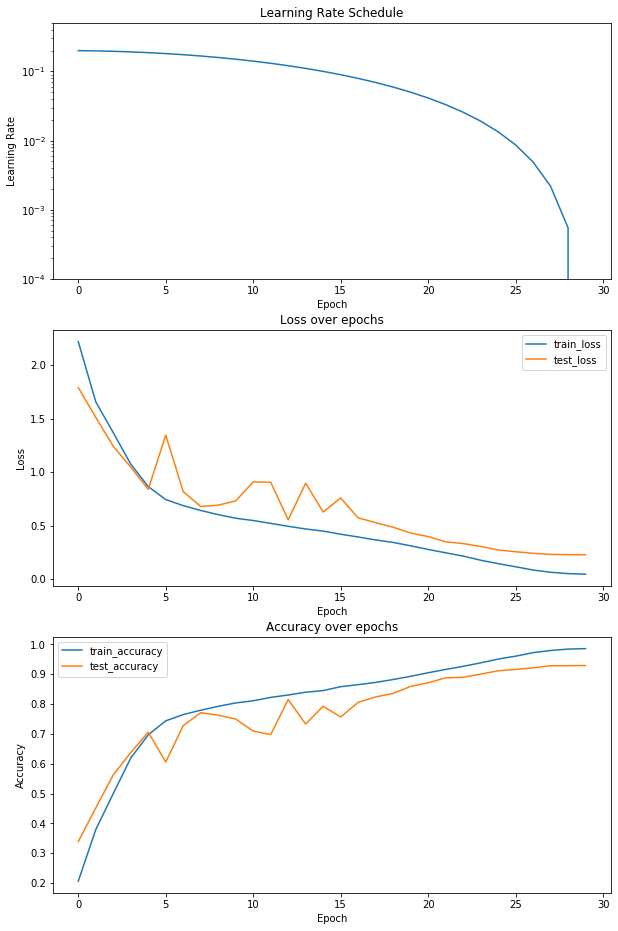

In [11]:
checkpoint = torch.load(f'{model_dir}_cosine_annealing_30')
r18 = resnet18(num_classes=10)
r18.to(device)
r18.load_state_dict(checkpoint['model_state_dict'])
evaluate(test_ds, r18, nn.CrossEntropyLoss())
plot_history(checkpoint['history'])

In [12]:
epochs = 60
model = resnet18(num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, epochs//3, 2)
history = train(train_ds, test_ds, optimizer, model, scheduler=scheduler, epochs=epochs)
torch.save({
    'model_state_dict': model.state_dict(),
    'opt_state_dict': optimizer.state_dict(),
    'history': history
}, f'{model_dir}_cosine_annealing_warm_restarts')

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 0: Loss: 2.383873942562991 Batch Accuracy: 0.14518


  2%|▏         | 1/60 [00:48<47:12, 48.01s/it]

Test Set evaluation: Loss: 1.9593717629396463 Test Accuracy: 0.1971
Epoch 1: Loss: 1.8918868937455784 Batch Accuracy: 0.2464


  3%|▎         | 2/60 [01:36<46:28, 48.07s/it]

Test Set evaluation: Loss: 1.7444033260586895 Test Accuracy: 0.3468
Epoch 2: Loss: 1.5825822335070052 Batch Accuracy: 0.4043


  5%|▌         | 3/60 [02:24<45:43, 48.13s/it]

Test Set evaluation: Loss: 1.7978749682631674 Test Accuracy: 0.3721
Epoch 3: Loss: 1.2827173364741722 Batch Accuracy: 0.53008


  7%|▋         | 4/60 [03:12<44:54, 48.12s/it]

Test Set evaluation: Loss: 1.3034205089641522 Test Accuracy: 0.5339
Epoch 4: Loss: 1.0789803341221627 Batch Accuracy: 0.6118


  8%|▊         | 5/60 [04:00<44:01, 48.03s/it]

Test Set evaluation: Loss: 1.3860602393934998 Test Accuracy: 0.547
Epoch 5: Loss: 0.9365751159465526 Batch Accuracy: 0.66902


 10%|█         | 6/60 [04:48<43:11, 47.99s/it]

Test Set evaluation: Loss: 0.9707878865773165 Test Accuracy: 0.6692
Epoch 6: Loss: 0.813430383687129 Batch Accuracy: 0.7139


 12%|█▏        | 7/60 [05:36<42:22, 47.96s/it]

Test Set evaluation: Loss: 0.9057669601862943 Test Accuracy: 0.6978
Epoch 7: Loss: 0.7186891329105553 Batch Accuracy: 0.7515


 13%|█▎        | 8/60 [06:24<41:34, 47.97s/it]

Test Set evaluation: Loss: 0.8808937118023257 Test Accuracy: 0.7051
Epoch 8: Loss: 0.655507709745251 Batch Accuracy: 0.77368


 15%|█▌        | 9/60 [07:12<40:50, 48.05s/it]

Test Set evaluation: Loss: 0.9405443381659592 Test Accuracy: 0.6897
Epoch 9: Loss: 0.5942956815137888 Batch Accuracy: 0.79536


 17%|█▋        | 10/60 [08:00<40:07, 48.16s/it]

Test Set evaluation: Loss: 1.0496011723445942 Test Accuracy: 0.677
Epoch 10: Loss: 0.5451285427488635 Batch Accuracy: 0.81268


 18%|█▊        | 11/60 [08:49<39:22, 48.21s/it]

Test Set evaluation: Loss: 0.8017108255549322 Test Accuracy: 0.7457
Epoch 11: Loss: 0.5012707094402264 Batch Accuracy: 0.8276


 20%|██        | 12/60 [09:37<38:30, 48.14s/it]

Test Set evaluation: Loss: 0.5734991397284255 Test Accuracy: 0.8013
Epoch 12: Loss: 0.44569032054270624 Batch Accuracy: 0.8461


 22%|██▏       | 13/60 [10:25<37:39, 48.07s/it]

Test Set evaluation: Loss: 0.591346538142313 Test Accuracy: 0.8058
Epoch 13: Loss: 0.39760261221462506 Batch Accuracy: 0.86344


 23%|██▎       | 14/60 [11:13<36:54, 48.14s/it]

Test Set evaluation: Loss: 0.5366219980052754 Test Accuracy: 0.8265
Epoch 14: Loss: 0.3498904943618628 Batch Accuracy: 0.87974


 25%|██▌       | 15/60 [12:01<36:08, 48.18s/it]

Test Set evaluation: Loss: 0.45740505147583876 Test Accuracy: 0.8453
Epoch 15: Loss: 0.29458123643684875 Batch Accuracy: 0.90006


 27%|██▋       | 16/60 [12:49<35:16, 48.10s/it]

Test Set evaluation: Loss: 0.41942163868040977 Test Accuracy: 0.8549
Epoch 16: Loss: 0.2508921177910112 Batch Accuracy: 0.91468


 28%|██▊       | 17/60 [13:37<34:29, 48.13s/it]

Test Set evaluation: Loss: 0.3418168321817736 Test Accuracy: 0.881
Epoch 17: Loss: 0.20243643271877332 Batch Accuracy: 0.93148


 30%|███       | 18/60 [14:25<33:40, 48.10s/it]

Test Set evaluation: Loss: 0.3110495603914502 Test Accuracy: 0.8976
Epoch 18: Loss: 0.16636908925174143 Batch Accuracy: 0.94406


 32%|███▏      | 19/60 [15:13<32:52, 48.10s/it]

Test Set evaluation: Loss: 0.27547209992816174 Test Accuracy: 0.9062
Epoch 19: Loss: 0.14098810822800603 Batch Accuracy: 0.95328


 33%|███▎      | 20/60 [16:01<32:01, 48.04s/it]

Test Set evaluation: Loss: 0.26777352920815917 Test Accuracy: 0.9106
Epoch 20: Loss: 0.7819596804926158 Batch Accuracy: 0.73136


 35%|███▌      | 21/60 [16:49<31:13, 48.03s/it]

Test Set evaluation: Loss: 0.9497397926789296 Test Accuracy: 0.6856
Epoch 21: Loss: 0.6477473910202456 Batch Accuracy: 0.77708


 37%|███▋      | 22/60 [17:38<30:28, 48.11s/it]

Test Set evaluation: Loss: 1.070227334016486 Test Accuracy: 0.6468
Epoch 22: Loss: 0.6112345710129994 Batch Accuracy: 0.78938


 38%|███▊      | 23/60 [18:26<29:41, 48.15s/it]

Test Set evaluation: Loss: 0.7726711268666424 Test Accuracy: 0.735
Epoch 23: Loss: 0.5964403082342709 Batch Accuracy: 0.79618


 40%|████      | 24/60 [19:14<28:53, 48.16s/it]

Test Set evaluation: Loss: 0.7934878830668293 Test Accuracy: 0.7409
Epoch 24: Loss: 0.5837914378899137 Batch Accuracy: 0.79884


 42%|████▏     | 25/60 [20:02<28:05, 48.16s/it]

Test Set evaluation: Loss: 0.689837969933884 Test Accuracy: 0.7654
Epoch 25: Loss: 0.5751945151544898 Batch Accuracy: 0.80358


 43%|████▎     | 26/60 [20:50<27:14, 48.08s/it]

Test Set evaluation: Loss: 0.8905339769170254 Test Accuracy: 0.7112
Epoch 26: Loss: 0.5566696770050946 Batch Accuracy: 0.80964


 45%|████▌     | 27/60 [21:38<26:28, 48.14s/it]

Test Set evaluation: Loss: 1.297298456294627 Test Accuracy: 0.6337
Epoch 27: Loss: 0.5487072805461981 Batch Accuracy: 0.8133


 47%|████▋     | 28/60 [22:26<25:39, 48.10s/it]

Test Set evaluation: Loss: 1.1553813083262383 Test Accuracy: 0.6597
Epoch 28: Loss: 0.5386964934866142 Batch Accuracy: 0.81662


 48%|████▊     | 29/60 [23:14<24:48, 48.02s/it]

Test Set evaluation: Loss: 0.6655650342567058 Test Accuracy: 0.7808
Epoch 29: Loss: 0.5273942788848487 Batch Accuracy: 0.81982


 50%|█████     | 30/60 [24:03<24:03, 48.12s/it]

Test Set evaluation: Loss: 0.6949639920192429 Test Accuracy: 0.7643
Epoch 30: Loss: 0.5157277527672556 Batch Accuracy: 0.8236


 52%|█████▏    | 31/60 [24:51<23:16, 48.16s/it]

Test Set evaluation: Loss: 0.8389368102520327 Test Accuracy: 0.7299
Epoch 31: Loss: 0.5009139060516796 Batch Accuracy: 0.82944


 53%|█████▎    | 32/60 [25:39<22:25, 48.05s/it]

Test Set evaluation: Loss: 0.6097895125799542 Test Accuracy: 0.7931
Epoch 32: Loss: 0.4919752379512543 Batch Accuracy: 0.83058


 55%|█████▌    | 33/60 [26:27<21:36, 48.01s/it]

Test Set evaluation: Loss: 0.7588123875328258 Test Accuracy: 0.7625
Epoch 33: Loss: 0.4784648116973355 Batch Accuracy: 0.83812


 57%|█████▋    | 34/60 [27:15<20:49, 48.04s/it]

Test Set evaluation: Loss: 0.9736897587021695 Test Accuracy: 0.7108
Epoch 34: Loss: 0.46834573248768097 Batch Accuracy: 0.84026


 58%|█████▊    | 35/60 [28:03<20:01, 48.05s/it]

Test Set evaluation: Loss: 0.7056251745435256 Test Accuracy: 0.7757
Epoch 35: Loss: 0.4590052070139009 Batch Accuracy: 0.84266


 60%|██████    | 36/60 [28:51<19:13, 48.05s/it]

Test Set evaluation: Loss: 0.5847259009186225 Test Accuracy: 0.8004
Epoch 36: Loss: 0.44315073930698895 Batch Accuracy: 0.84906


 62%|██████▏   | 37/60 [29:39<18:24, 48.04s/it]

Test Set evaluation: Loss: 0.4875319102142431 Test Accuracy: 0.8379
Epoch 37: Loss: 0.4249045260422065 Batch Accuracy: 0.85478


 63%|██████▎   | 38/60 [30:27<17:37, 48.05s/it]

Test Set evaluation: Loss: 0.5542678086063529 Test Accuracy: 0.8116
Epoch 38: Loss: 0.4130098897096751 Batch Accuracy: 0.85956


 65%|██████▌   | 39/60 [31:15<16:50, 48.11s/it]

Test Set evaluation: Loss: 0.6182112595703029 Test Accuracy: 0.784
Epoch 39: Loss: 0.39382740211151446 Batch Accuracy: 0.8641


 67%|██████▋   | 40/60 [32:04<16:04, 48.24s/it]

Test Set evaluation: Loss: 0.6515706966194925 Test Accuracy: 0.7866
Epoch 40: Loss: 0.37482881671784785 Batch Accuracy: 0.87134


 68%|██████▊   | 41/60 [32:52<15:16, 48.24s/it]

Test Set evaluation: Loss: 0.692667781552182 Test Accuracy: 0.7751
Epoch 41: Loss: 0.36200192696450617 Batch Accuracy: 0.87666


 70%|███████   | 42/60 [33:40<14:27, 48.20s/it]

Test Set evaluation: Loss: 0.5139098703106747 Test Accuracy: 0.8321
Epoch 42: Loss: 0.3423822673461626 Batch Accuracy: 0.88456


 72%|███████▏  | 43/60 [34:28<13:39, 48.20s/it]

Test Set evaluation: Loss: 0.6239847250377075 Test Accuracy: 0.7999
Epoch 43: Loss: 0.3215941744463523 Batch Accuracy: 0.88986


 73%|███████▎  | 44/60 [35:16<12:50, 48.18s/it]

Test Set evaluation: Loss: 0.3849532368439662 Test Accuracy: 0.8671
Epoch 44: Loss: 0.3049204679553771 Batch Accuracy: 0.89472


 75%|███████▌  | 45/60 [36:04<12:02, 48.14s/it]

Test Set evaluation: Loss: 0.40386169413222545 Test Accuracy: 0.8625
Epoch 45: Loss: 0.2826350814165057 Batch Accuracy: 0.9031


 77%|███████▋  | 46/60 [36:52<11:13, 48.13s/it]

Test Set evaluation: Loss: 0.39603586589233786 Test Accuracy: 0.869
Epoch 46: Loss: 0.2629457525623119 Batch Accuracy: 0.90934


 78%|███████▊  | 47/60 [37:41<10:26, 48.21s/it]

Test Set evaluation: Loss: 0.38314221252368974 Test Accuracy: 0.8709
Epoch 47: Loss: 0.23578056155720636 Batch Accuracy: 0.91922


 80%|████████  | 48/60 [38:29<09:37, 48.10s/it]

Test Set evaluation: Loss: 0.3499072763738753 Test Accuracy: 0.8828
Epoch 48: Loss: 0.2186135802122638 Batch Accuracy: 0.9249


 82%|████████▏ | 49/60 [39:17<08:49, 48.09s/it]

Test Set evaluation: Loss: 0.2922548076397256 Test Accuracy: 0.9012
Epoch 49: Loss: 0.19166232887512583 Batch Accuracy: 0.93382


 83%|████████▎ | 50/60 [40:05<08:01, 48.11s/it]

Test Set evaluation: Loss: 0.37697878951513314 Test Accuracy: 0.8766
Epoch 50: Loss: 0.16466770365910458 Batch Accuracy: 0.9439


 85%|████████▌ | 51/60 [40:53<07:12, 48.09s/it]

Test Set evaluation: Loss: 0.3376639179791076 Test Accuracy: 0.8943
Epoch 51: Loss: 0.14343429711240027 Batch Accuracy: 0.95126


 87%|████████▋ | 52/60 [41:41<06:25, 48.15s/it]

Test Set evaluation: Loss: 0.2898998424599442 Test Accuracy: 0.9052
Epoch 52: Loss: 0.12156204303340687 Batch Accuracy: 0.95792


 88%|████████▊ | 53/60 [42:29<05:36, 48.14s/it]

Test Set evaluation: Loss: 0.25725543046299415 Test Accuracy: 0.9171
Epoch 53: Loss: 0.0921895617614393 Batch Accuracy: 0.96898


 90%|█████████ | 54/60 [43:17<04:48, 48.11s/it]

Test Set evaluation: Loss: 0.24450337971690334 Test Accuracy: 0.9247
Epoch 54: Loss: 0.0736711695170997 Batch Accuracy: 0.97572


 92%|█████████▏| 55/60 [44:05<04:00, 48.06s/it]

Test Set evaluation: Loss: 0.24076874879530713 Test Accuracy: 0.9278
Epoch 55: Loss: 0.054076374822851186 Batch Accuracy: 0.98252


 93%|█████████▎| 56/60 [44:53<03:11, 47.99s/it]

Test Set evaluation: Loss: 0.2168251319399363 Test Accuracy: 0.9327
Epoch 56: Loss: 0.04225553613146553 Batch Accuracy: 0.98644


 95%|█████████▌| 57/60 [45:41<02:24, 48.04s/it]

Test Set evaluation: Loss: 0.2130185221852381 Test Accuracy: 0.9346
Epoch 57: Loss: 0.033830859442301034 Batch Accuracy: 0.98986


 97%|█████████▋| 58/60 [46:29<01:36, 48.06s/it]

Test Set evaluation: Loss: 0.2142341488241395 Test Accuracy: 0.9375
Epoch 58: Loss: 0.02897505871856304 Batch Accuracy: 0.99154


 98%|█████████▊| 59/60 [47:17<00:47, 47.98s/it]

Test Set evaluation: Loss: 0.2132528813296481 Test Accuracy: 0.9373
Epoch 59: Loss: 0.0265767128549783 Batch Accuracy: 0.99274


100%|██████████| 60/60 [48:05<00:00, 48.09s/it]

Test Set evaluation: Loss: 0.20780873105307168 Test Accuracy: 0.937


Test Set evaluation: Loss: 0.20780873105307168 Test Accuracy: 0.937


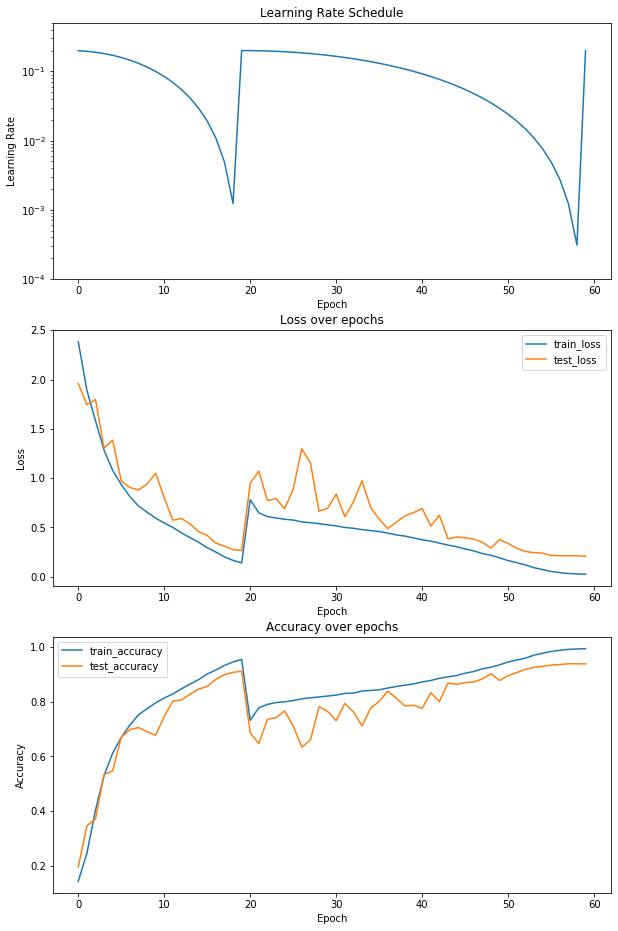

In [13]:
checkpoint = torch.load(f'{model_dir}_cosine_annealing_warm_restarts')
r18 = resnet18(num_classes=10)
r18.to(device)
r18.load_state_dict(checkpoint['model_state_dict'])
evaluate(test_ds, r18, nn.CrossEntropyLoss())
plot_history(checkpoint['history'])

In [14]:
epochs = 50
model = resnet18(num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.1, total_steps=(epochs * math.ceil(50000/HPS['batch_size'])))
history = train(train_ds, test_ds, optimizer, model, epochs=epochs, batch_scheduler=scheduler)
torch.save({
    'model_state_dict': model.state_dict(),
    'opt_state_dict': optimizer.state_dict(),
    'history': history
}, f'{model_dir}_one_cycle_lr')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Loss: 1.619880828711078 Batch Accuracy: 0.39716


  2%|▏         | 1/50 [00:48<39:12, 48.01s/it]

Test Set evaluation: Loss: 1.3833799875235255 Test Accuracy: 0.5007
Epoch 1: Loss: 1.200251747122811 Batch Accuracy: 0.5677


  4%|▍         | 2/50 [01:36<38:27, 48.08s/it]

Test Set evaluation: Loss: 1.2493931892551953 Test Accuracy: 0.5764


  4%|▍         | 2/50 [01:56<46:31, 58.16s/it]


KeyboardInterrupt: 

Test Set evaluation: Loss: 0.20108654651838012 Test Accuracy: 0.9465


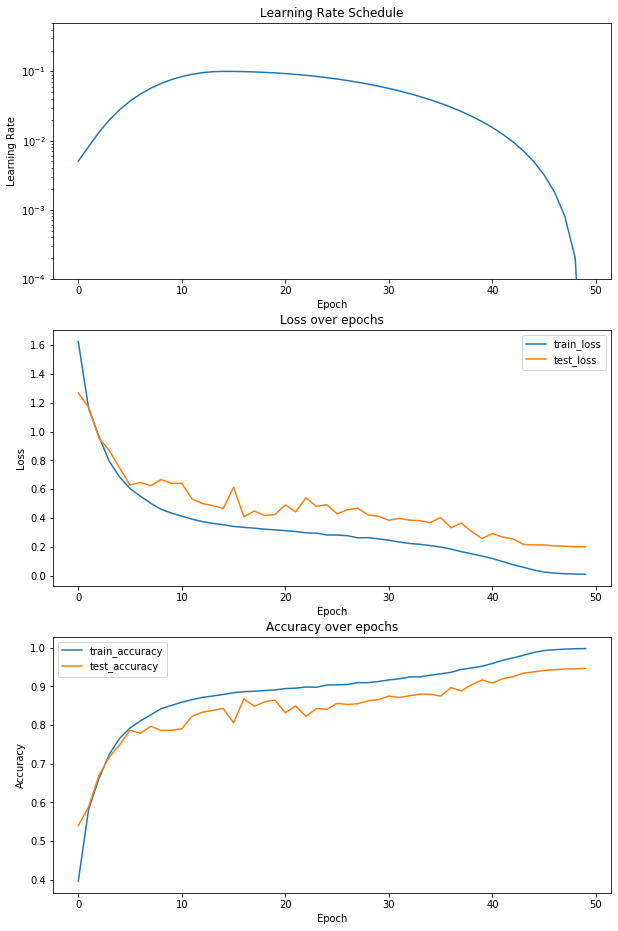

In [15]:
checkpoint = torch.load(f'{model_dir}_one_cycle_lr')
r18 = resnet18(num_classes=10)
r18.to(device)
r18.load_state_dict(checkpoint['model_state_dict'])
evaluate(test_ds, r18, nn.CrossEntropyLoss())
plot_history(checkpoint['history'])

In [ ]:
epochs = 30
model = resnet18(num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.1, total_steps=(epochs * math.ceil(50000/HPS['batch_size'])))
history = train(train_ds, test_ds, optimizer, model, epochs=epochs, batch_scheduler=scheduler)
torch.save({
    'model_state_dict': model.state_dict(),
    'opt_state_dict': optimizer.state_dict(),
    'history': history
}, f'{model_dir}_one_cycle_lr_30')

Test Set evaluation: Loss: 0.20495548184159434 Test Accuracy: 0.9377


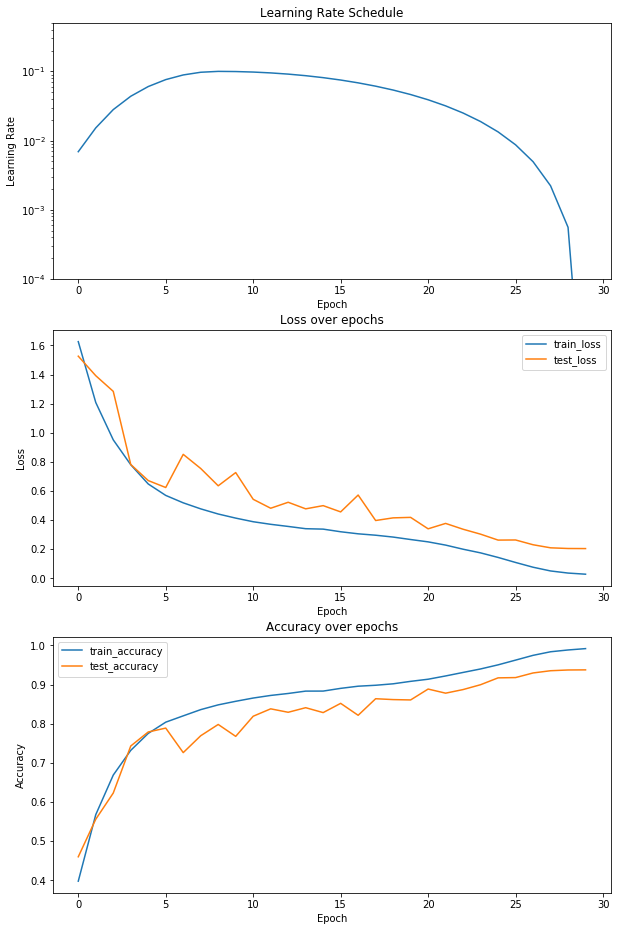

In [16]:
checkpoint = torch.load(f'{model_dir}_one_cycle_lr_30')
r18 = resnet18(num_classes=10)
r18.to(device)
r18.load_state_dict(checkpoint['model_state_dict'])
evaluate(test_ds, r18, nn.CrossEntropyLoss())
plot_history(checkpoint['history'])

In [ ]:
epochs = 20
model = resnet18(num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.1, total_steps=(epochs * math.ceil(50000/HPS['batch_size'])))
history1 = train(train_ds, test_ds, optimizer, model, epochs=epochs, batch_scheduler=scheduler)

swa_model = AveragedModel(model, device=device)
optimizer = torch.optim.SGD(r18.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
history2 = train(train_ds, test_ds, optimizer, r18, epochs=20, swa_model=swa_model)

torch.save({
    'model_state_dict': swa_model.state_dict(),
    'opt_state_dict': optimizer.state_dict(),
    'history': history1 + history2
}, f'{model_dir}_one_cycle_lr_swa_20_20')

Test Set evaluation: Loss: 0.19968735464388812 Test Accuracy: 0.9445


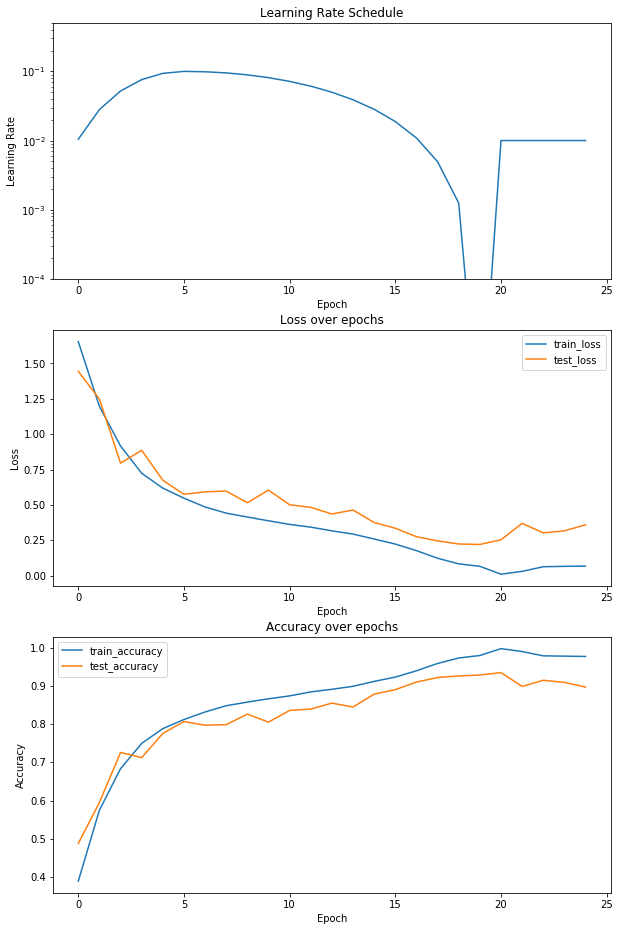

In [18]:
checkpoint = torch.load(f'{model_dir}_one_cycle_lr_swa_20_20')
r18 = AveragedModel(resnet18(num_classes=10), device=device)
r18.load_state_dict(checkpoint['model_state_dict'])
update_bn(train_ds, r18, device=device)
evaluate(test_ds, r18, nn.CrossEntropyLoss())
plot_history(checkpoint['history'])

Test Set evaluation: Loss: 0.22909499549224407 Test Accuracy: 0.9414


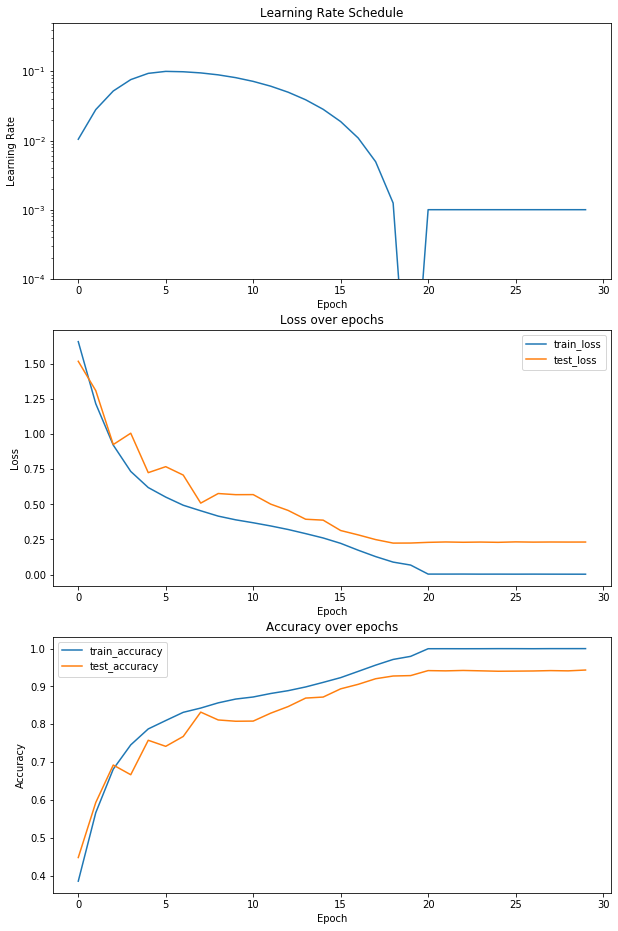

In [20]:
checkpoint = torch.load(f'{model_dir}_one_cycle_lr_swa_20_10')
r18 = AveragedModel(resnet18(num_classes=10), device=device)
r18.load_state_dict(checkpoint['model_state_dict'])
update_bn(train_ds, r18, device=device)
evaluate(test_ds, r18, nn.CrossEntropyLoss())
plot_history(checkpoint['history'])

In [24]:
epochs = 50
model = resnet18(num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,40])
history = train(train_ds, test_ds, optimizer, model, epochs=epochs, scheduler=scheduler)
torch.save({
    'model_state_dict': model.state_dict(),
    'opt_state_dict': optimizer.state_dict(),
    'history': history
}, f'{model_dir}_multi_step_lr')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Loss: 1.6923753053635893 Batch Accuracy: 0.37818


  2%|▏         | 1/50 [00:46<38:17, 46.88s/it]

Test Set evaluation: Loss: 1.4106916626797448 Test Accuracy: 0.4966
Epoch 1: Loss: 1.1287213530381928 Batch Accuracy: 0.59388


  4%|▍         | 2/50 [01:34<37:38, 47.04s/it]

Test Set evaluation: Loss: 0.9889719946474969 Test Accuracy: 0.6398
Epoch 2: Loss: 0.8461991845799224 Batch Accuracy: 0.70268


  6%|▌         | 3/50 [02:21<36:53, 47.10s/it]

Test Set evaluation: Loss: 0.8087943226476259 Test Accuracy: 0.7186
Epoch 3: Loss: 0.6884619898503394 Batch Accuracy: 0.76078


  8%|▊         | 4/50 [03:08<36:06, 47.11s/it]

Test Set evaluation: Loss: 0.8313979031164435 Test Accuracy: 0.7165
Epoch 4: Loss: 0.5890115477392436 Batch Accuracy: 0.79488


 10%|█         | 5/50 [03:56<35:30, 47.34s/it]

Test Set evaluation: Loss: 0.7680234048939958 Test Accuracy: 0.7508
Epoch 5: Loss: 0.5324026856123639 Batch Accuracy: 0.81396


 12%|█▏        | 6/50 [04:44<34:52, 47.55s/it]

Test Set evaluation: Loss: 0.7644935288006747 Test Accuracy: 0.7406
Epoch 6: Loss: 0.4762420004514782 Batch Accuracy: 0.83536


 14%|█▍        | 7/50 [05:32<34:09, 47.67s/it]

Test Set evaluation: Loss: 0.56401515497437 Test Accuracy: 0.8121
Epoch 7: Loss: 0.4423788737915361 Batch Accuracy: 0.84684


 16%|█▌        | 8/50 [06:20<33:29, 47.84s/it]

Test Set evaluation: Loss: 0.5258063447626331 Test Accuracy: 0.8218
Epoch 8: Loss: 0.4100699217423149 Batch Accuracy: 0.85816


 18%|█▊        | 9/50 [07:09<32:46, 47.97s/it]

Test Set evaluation: Loss: 0.5185192691374428 Test Accuracy: 0.8305
Epoch 9: Loss: 0.38842108209267295 Batch Accuracy: 0.86732


 20%|██        | 10/50 [07:57<32:00, 48.00s/it]

Test Set evaluation: Loss: 0.4964796625360658 Test Accuracy: 0.8311
Epoch 10: Loss: 0.36350235198159964 Batch Accuracy: 0.87516


 22%|██▏       | 11/50 [08:45<31:14, 48.06s/it]

Test Set evaluation: Loss: 0.4821594730962681 Test Accuracy: 0.8396
Epoch 11: Loss: 0.34841495211167106 Batch Accuracy: 0.8798


 24%|██▍       | 12/50 [09:33<30:31, 48.19s/it]

Test Set evaluation: Loss: 0.5706260426889492 Test Accuracy: 0.8163
Epoch 12: Loss: 0.33246467291089277 Batch Accuracy: 0.88376


 26%|██▌       | 13/50 [10:21<29:42, 48.16s/it]

Test Set evaluation: Loss: 0.4892194259770309 Test Accuracy: 0.8371
Epoch 13: Loss: 0.32066114643193266 Batch Accuracy: 0.89064


 28%|██▊       | 14/50 [11:10<28:57, 48.25s/it]

Test Set evaluation: Loss: 0.4486070612940607 Test Accuracy: 0.8518
Epoch 14: Loss: 0.3129847055239141 Batch Accuracy: 0.89208


 30%|███       | 15/50 [11:58<28:06, 48.18s/it]

Test Set evaluation: Loss: 0.52845352699485 Test Accuracy: 0.8304
Epoch 15: Loss: 0.31206896657224203 Batch Accuracy: 0.89386


 32%|███▏      | 16/50 [12:46<27:16, 48.12s/it]

Test Set evaluation: Loss: 0.40681219440472277 Test Accuracy: 0.8631
Epoch 16: Loss: 0.29404886520427204 Batch Accuracy: 0.89854


 34%|███▍      | 17/50 [13:34<26:26, 48.08s/it]

Test Set evaluation: Loss: 0.42375915110865725 Test Accuracy: 0.8551
Epoch 17: Loss: 0.2911388473132687 Batch Accuracy: 0.9002


 36%|███▌      | 18/50 [14:22<25:38, 48.07s/it]

Test Set evaluation: Loss: 0.39026661311523825 Test Accuracy: 0.8698
Epoch 18: Loss: 0.28676863228116195 Batch Accuracy: 0.90036


 38%|███▊      | 19/50 [15:10<24:52, 48.13s/it]

Test Set evaluation: Loss: 0.4556615288499035 Test Accuracy: 0.8451
Epoch 19: Loss: 0.2784291629862907 Batch Accuracy: 0.90554


 40%|████      | 20/50 [15:58<24:02, 48.09s/it]

Test Set evaluation: Loss: 0.4069423356765433 Test Accuracy: 0.8656
Epoch 20: Loss: 0.2714437203448447 Batch Accuracy: 0.9077


 42%|████▏     | 21/50 [16:46<23:13, 48.05s/it]

Test Set evaluation: Loss: 0.49900369855422005 Test Accuracy: 0.8426
Epoch 21: Loss: 0.2730761825504815 Batch Accuracy: 0.90676


 44%|████▍     | 22/50 [17:34<22:24, 48.03s/it]

Test Set evaluation: Loss: 0.4159742820112011 Test Accuracy: 0.8614
Epoch 22: Loss: 0.2645893002028965 Batch Accuracy: 0.90998


 46%|████▌     | 23/50 [18:22<21:35, 47.99s/it]

Test Set evaluation: Loss: 0.43015768331817433 Test Accuracy: 0.8577
Epoch 23: Loss: 0.2614889219593819 Batch Accuracy: 0.91


 48%|████▊     | 24/50 [19:10<20:50, 48.09s/it]

Test Set evaluation: Loss: 0.5121665223489834 Test Accuracy: 0.842
Epoch 24: Loss: 0.2570208919132152 Batch Accuracy: 0.91282


 50%|█████     | 25/50 [19:59<20:03, 48.12s/it]

Test Set evaluation: Loss: 0.41615130026129227 Test Accuracy: 0.8658
Epoch 25: Loss: 0.13840590780386536 Batch Accuracy: 0.95384


 52%|█████▏    | 26/50 [20:47<19:15, 48.16s/it]

Test Set evaluation: Loss: 0.2237059540009197 Test Accuracy: 0.9258
Epoch 26: Loss: 0.10107033346753444 Batch Accuracy: 0.96746


 54%|█████▍    | 27/50 [21:35<18:28, 48.21s/it]

Test Set evaluation: Loss: 0.21568638718203653 Test Accuracy: 0.9304
Epoch 27: Loss: 0.08506017684212426 Batch Accuracy: 0.97152


 56%|█████▌    | 28/50 [22:24<17:41, 48.27s/it]

Test Set evaluation: Loss: 0.21751015416429012 Test Accuracy: 0.9319
Epoch 28: Loss: 0.07630161254588143 Batch Accuracy: 0.97502


 58%|█████▊    | 29/50 [23:12<16:52, 48.23s/it]

Test Set evaluation: Loss: 0.2175069807828227 Test Accuracy: 0.9334
Epoch 29: Loss: 0.06701208449080777 Batch Accuracy: 0.9777


 60%|██████    | 30/50 [24:00<16:03, 48.19s/it]

Test Set evaluation: Loss: 0.21720081454590906 Test Accuracy: 0.9325
Epoch 30: Loss: 0.06050233837798276 Batch Accuracy: 0.9809


 62%|██████▏   | 31/50 [24:48<15:14, 48.14s/it]

Test Set evaluation: Loss: 0.21754298519484605 Test Accuracy: 0.9326
Epoch 31: Loss: 0.05535971352597103 Batch Accuracy: 0.98246


 64%|██████▍   | 32/50 [25:36<14:28, 48.23s/it]

Test Set evaluation: Loss: 0.22100539444179473 Test Accuracy: 0.9343
Epoch 32: Loss: 0.04914573190943398 Batch Accuracy: 0.98442


 66%|██████▌   | 33/50 [26:24<13:39, 48.22s/it]

Test Set evaluation: Loss: 0.21778307973018177 Test Accuracy: 0.9357
Epoch 33: Loss: 0.04408914615135745 Batch Accuracy: 0.98604


 68%|██████▊   | 34/50 [27:13<12:52, 48.26s/it]

Test Set evaluation: Loss: 0.23368471549658837 Test Accuracy: 0.9317
Epoch 34: Loss: 0.039151591360759554 Batch Accuracy: 0.98752


 70%|███████   | 35/50 [28:01<12:03, 48.21s/it]

Test Set evaluation: Loss: 0.2309558905566795 Test Accuracy: 0.9345
Epoch 35: Loss: 0.03787803557008276 Batch Accuracy: 0.98824


 72%|███████▏  | 36/50 [28:49<11:14, 48.16s/it]

Test Set evaluation: Loss: 0.2303136791798133 Test Accuracy: 0.9337
Epoch 36: Loss: 0.03449705443547472 Batch Accuracy: 0.98902


 74%|███████▍  | 37/50 [29:37<10:25, 48.13s/it]

Test Set evaluation: Loss: 0.2402845190107068 Test Accuracy: 0.9327
Epoch 37: Loss: 0.03103122449792026 Batch Accuracy: 0.9902


 76%|███████▌  | 38/50 [30:25<09:37, 48.12s/it]

Test Set evaluation: Loss: 0.23688211787161947 Test Accuracy: 0.9364
Epoch 38: Loss: 0.02787403926572493 Batch Accuracy: 0.9917


 78%|███████▊  | 39/50 [31:13<08:49, 48.13s/it]

Test Set evaluation: Loss: 0.2383871548160722 Test Accuracy: 0.9338
Epoch 39: Loss: 0.026726265614161557 Batch Accuracy: 0.99182


 80%|████████  | 40/50 [32:01<08:01, 48.15s/it]

Test Set evaluation: Loss: 0.25055381297310697 Test Accuracy: 0.9316
Epoch 40: Loss: 0.022129475398113014 Batch Accuracy: 0.99418


 82%|████████▏ | 41/50 [32:50<07:13, 48.14s/it]

Test Set evaluation: Loss: 0.23265017111656033 Test Accuracy: 0.9368
Epoch 41: Loss: 0.018759134741823957 Batch Accuracy: 0.99496


 84%|████████▍ | 42/50 [33:37<06:24, 48.05s/it]

Test Set evaluation: Loss: 0.2297503567194637 Test Accuracy: 0.9388
Epoch 42: Loss: 0.016502909837505016 Batch Accuracy: 0.99576


 86%|████████▌ | 43/50 [34:25<05:36, 48.01s/it]

Test Set evaluation: Loss: 0.23069509736533406 Test Accuracy: 0.9378
Epoch 43: Loss: 0.015738362003989575 Batch Accuracy: 0.9962


 88%|████████▊ | 44/50 [35:13<04:48, 48.03s/it]

Test Set evaluation: Loss: 0.22924142217711557 Test Accuracy: 0.9394
Epoch 44: Loss: 0.01596126678790373 Batch Accuracy: 0.99578


 90%|█████████ | 45/50 [36:02<04:00, 48.07s/it]

Test Set evaluation: Loss: 0.2301587966046756 Test Accuracy: 0.939
Epoch 45: Loss: 0.014155201250067948 Batch Accuracy: 0.9966


 92%|█████████▏| 46/50 [36:50<03:12, 48.20s/it]

Test Set evaluation: Loss: 0.22930835291177412 Test Accuracy: 0.9389
Epoch 46: Loss: 0.014598678517312554 Batch Accuracy: 0.99668


 94%|█████████▍| 47/50 [37:38<02:24, 48.18s/it]

Test Set evaluation: Loss: 0.22955363474880594 Test Accuracy: 0.9393
Epoch 47: Loss: 0.014012426083140513 Batch Accuracy: 0.99656


 96%|█████████▌| 48/50 [38:26<01:36, 48.13s/it]

Test Set evaluation: Loss: 0.23273633995765372 Test Accuracy: 0.9382
Epoch 48: Loss: 0.013789449477225275 Batch Accuracy: 0.99674


 98%|█████████▊| 49/50 [39:14<00:48, 48.19s/it]

Test Set evaluation: Loss: 0.23204983516207225 Test Accuracy: 0.9383
Epoch 49: Loss: 0.012680159968054851 Batch Accuracy: 0.99722


100%|██████████| 50/50 [40:03<00:00, 48.06s/it]

Test Set evaluation: Loss: 0.23094320217076736 Test Accuracy: 0.9376


Test Set evaluation: Loss: 0.23094320217076736 Test Accuracy: 0.9376


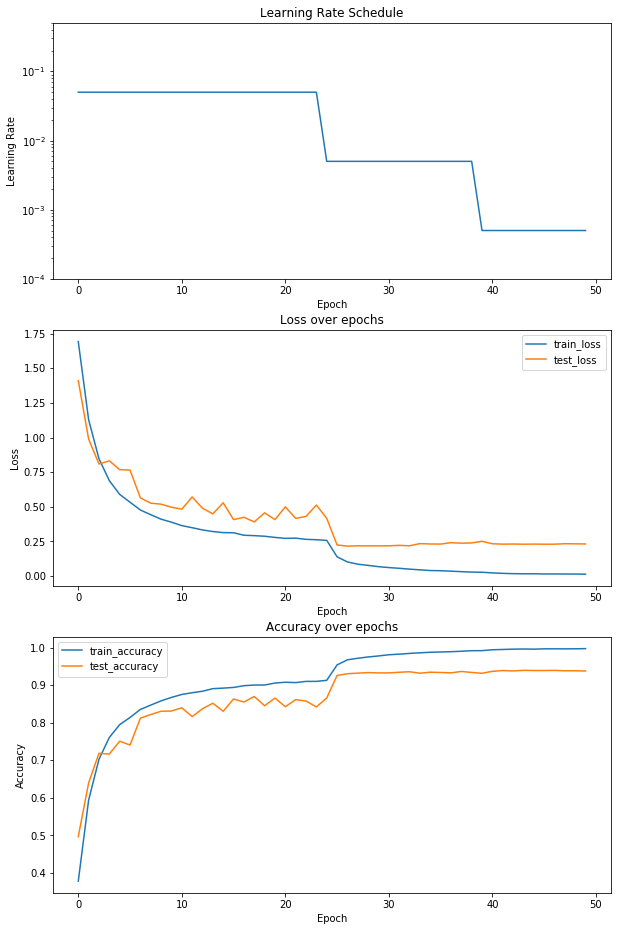

In [25]:
checkpoint = torch.load(f'{model_dir}_multi_step_lr')
r18 = resnet18(num_classes=10)
r18.to(device)
r18.load_state_dict(checkpoint['model_state_dict'])
evaluate(test_ds, r18, nn.CrossEntropyLoss())
plot_history(checkpoint['history'])